# Problem: Classifying Sneakers versus Sandals
## Summarising the datasets

In [ ]:
import pandas as pd

# Read the FMNIST training set and labels CSV file
train_labels = pd.read_csv('FMNIST_training_set_labels.csv', header=None, names=['label'])
train_set = pd.read_csv('FMNIST_training_set.csv', header=None)

# Read the FMNIST test set and labels CSV file
test_labels = pd.read_csv('FMNIST_test_set_labels.csv', header=None, names=['label'])
test_set = pd.read_csv('FMNIST_test_set.csv', header=None)

# Filter the set and labels to only include sneakers (7) and sandals (5)
ss_train_labels = train_labels[train_labels['label'].isin([5, 7])].copy()
ss_train_set = train_set[train_labels['label'].isin([5, 7])].copy()
ss_test_labels = test_labels[test_labels['label'].isin([5, 7])].copy()
ss_test_set = test_set[test_labels['label'].isin([5, 7])].copy()

# Replace the labels with 0 for sandals and 1 for sneakers
ss_train_labels['label'] = ss_train_labels['label'].replace({5: 1, 7: 0})
ss_test_labels['label'] = ss_test_labels['label'].replace({5: 1, 7: 0})

# Combined training data and testing data
ss_train = pd.concat([ss_train_labels, ss_train_set], axis=1)
ss_test = pd.concat([ss_test_labels, ss_test_set], axis=1)

# Get number of instances in the training set, test set, and total
num_train_instances = len(ss_train_set)
num_test_instances = len(ss_test_set)
num_total_instances = num_train_instances + num_test_instances

# Print D1
print('D1\n======================')
print('Number of training instances:', num_train_instances)
print('Number of test instances:', num_test_instances)
print('Total number of instances:', num_total_instances)

Number of training instances: 11988
Number of test instances: 2000
Total number of instances: 13988


In [ ]:
import matplotlib.pyplot as plt

# Get the counts of each class label in the training set and test set
train_label_counts = ss_train['label'].value_counts()
# test_label_counts = ss_test_labels['label'].value_counts()

# Check if the training set is imbalanced
if abs(train_label_counts[0] - train_label_counts[1]) > 0.5 * num_train_instances:
    print('The training set is imbalanced.')
else:
    print('The training set is balanced.')

# Print D2
print('D2\n======================')
plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts.values, alpha=0.5, label='Training Set')
# plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.5, label='Test Set')
plt.xticks([0, 1], ['Sneakers', 'Sandals'])
plt.xlabel('Class Label')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class Label')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# First six images/examples from each class
sneakers_idx = ss_train_labels[ss_train_labels['label'] == 0].index[:6]
sandals_idx = ss_train_labels[ss_train_labels['label'] == 1].index[:6]
sneakers_images = ss_train_set.loc[sneakers_idx].values.reshape(-1, 28, 28)
sandals_image = ss_train_set.loc[sandals_idx].values.reshape(-1, 28, 28)

# Combine the images into a single array
images = np.concatenate([sneakers_images, sandals_image])
indices = np.concatenate([sneakers_idx, sandals_idx])

# Print D3
print('D3\n======================')
# Plot the first six images/examples from each class
fig, axs = plt.subplots(3, 4, figsize=(8, 8))
plt.suptitle('First Six Images/Examples from Each Class', fontsize=16)
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"example {indices[i]}, y={ss_train_labels.loc[indices[i]]['label']}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Fitting your logistic regression classifier

In [140]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the training set into training and validation sets
training_data, validation_data = train_test_split(ss_train, test_size=0.2, random_state=5508)
training_x = training_data.drop('label', axis=1)
training_y = training_data['label']
validation_x = validation_data.drop('label', axis=1)
validation_y = validation_data['label']

# Sigmoid function
def sigmoid_func(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        return np.exp(x) / (1 + np.exp(x))

def sigmoid(x):
    return np.array([sigmoid_func(value) for value in x])

# Loss function
def loss(theta, X, y, m):
    est_p = sigmoid(X.dot(theta))
    epsilon = 1e-5
    return -1/m * np.sum(y.dot(np.log(est_p + epsilon)) + (1-y).dot(np.log(1-est_p + epsilon)))

# Predict function
def predict(theta, X):
    h = sigmoid(np.dot(X, theta))
    y_pred = np.where(h >= 0.5, 1, 0)
    return y_pred

# Gradient Descent function
def gradient_descent(theta, X, y, learning_rate, num_iterations):
    m = len(y)
    cost_history = []
    misclass_history = []
    for i in range(num_iterations):
        est_p = sigmoid(X.dot(theta))           # compute the estimated probability for each instance
        gradients = 2/m * X.T.dot(est_p - y)    # calculate the gradient vector using all instances
        theta -= learning_rate * gradients      # update the parameter vector
        lr_cost_train = loss(theta, X, y, m)    # calculate the logistic regression cost function
        lr_cost_val = loss(theta, validation_x, validation_y, len(validation_y))
        cost_history.append((lr_cost_train, lr_cost_val))
        
        # Calculate the misclassification rate for the training and validation sets
        y_pred_train = predict(theta, X)
        y_pred_val = predict(theta, validation_x)
        misclass_rate_train = np.mean(y_pred_train != y)
        misclass_rate_val = np.mean(y_pred_val != validation_y)
        misclass_history.append((misclass_rate_train, misclass_rate_val))
    return theta, cost_history, misclass_history

# Initialize the parameters
num_iterations = 100
learning_rate = 0.01
theta = np.random.randn(training_x.shape[1])

# Train the logistic regression model
theta, cost_history, misclass_history = gradient_descent(theta, training_x, training_y, learning_rate, num_iterations)

# Calculate the accuracy of the model
y_pred = predict(theta, validation_x)
accuracy = accuracy_score(validation_y, y_pred)
print('Accuracy:', accuracy)
print('Cost:\n(Training, Validation)')
for cost in cost_history:
    print(cost)
print('Misclass:\n(Training, Validation)')
for misclass in misclass_history:
    print(misclass)

Accuracy: 0.9399499582985822
Cost:
(Training, Validation)
(5.76005927645118, 5.742054560535659)
(5.748053494266444, 5.766059847159762)
(3.366118640341035, 3.3694188562439424)
(4.393176183763299, 4.484797507242339)
(5.680063547681711, 5.681897611596822)
(5.6413410297247015, 5.6844418726377794)
(2.956413609472515, 2.995668274231205)
(2.7116796777121523, 2.8144214536041687)
(3.5218892406903977, 3.5884718782599703)
(3.8771888446949982, 3.808533065720716)
(4.802136271272594, 4.853858904624936)
(2.1358731066953025, 2.2900939239606157)
(2.6982397378652716, 2.8026897671254747)
(3.3980849018215085, 3.408745704512949)
(4.5650232453031325, 4.6598807846652415)
(2.1389927540783686, 2.1955054630141113)
(3.095155023709444, 3.2454112394124444)
(3.255501309425353, 3.2360058607431696)
(4.410454499128635, 4.460337709027623)
(1.9380170678058053, 1.9188683129817352)
(2.6775117293133555, 2.8470169935523955)
(2.7032815708886497, 2.6356398625614283)
(3.8502638922354544, 3.980066522326427)
(2.3587773678685275,

D4


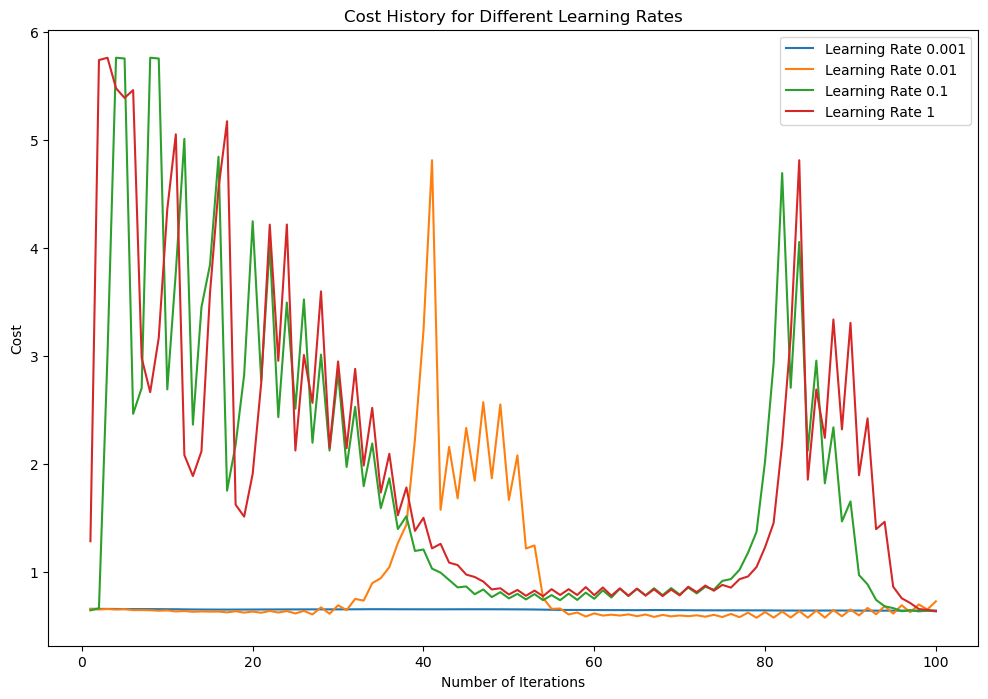

In [139]:
import matplotlib.pyplot as plt

# Print D4
print('D4\n======================')
plt.figure(figsize=(12, 8))

learning_rates = [0.001, 0.01, 0.1, 1]
for lr in learning_rates:
    _,cost_history,_ = gradient_descent(theta.copy(), training_x, training_y, lr, num_iterations)
    cost_history_train = [cost[0] for cost in cost_history]
    plt.plot(range(1, num_iterations + 1), cost_history_train, label=f'Learning Rate {lr}')

plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost History for Different Learning Rates')
plt.legend()
plt.show()

D5


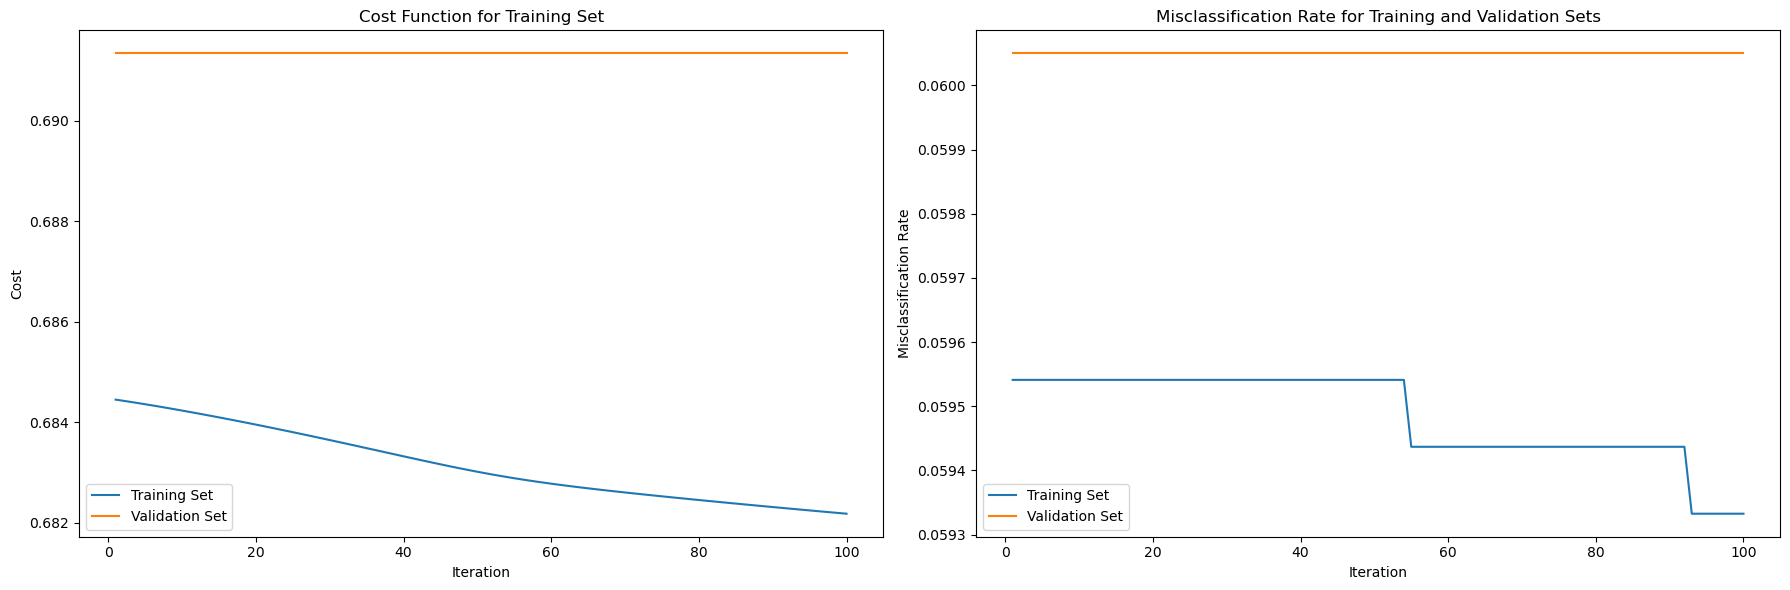

In [141]:


learning_rate = 1e-5
_, cost_history, misclass_history = gradient_descent(theta, training_x, training_y, learning_rate, num_iterations)

# Print D5
print('D5\n======================')
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Cost function for each iteration
train_costs = [cost[0] for cost in cost_history]
val_costs = [cost[1] for cost in cost_history]
axs[0].plot(range(1, num_iterations + 1), train_costs, label='Training Set')
axs[0].plot(range(1, num_iterations + 1), val_costs, label='Validation Set')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Function for Training Set and Validation Set')
axs[0].legend()

# Right plot: Misclassification rate for each iteration
misclass_history = np.array(misclass_history)
axs[1].plot(range(1, num_iterations + 1), misclass_history[:, 0], label='Training Set')
axs[1].plot(range(1, num_iterations + 1), misclass_history[:, 1], label='Validation Set')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for Training Set and Validation Set')
axs[1].legend()

plt.tight_layout()
plt.show()

## Using cross-validation and Scikit-learn logistic regression classifier

In [143]:
num_iterations = 100
learning_rate = 0.01

C_range = np.logspace(-10, 5, 30)
best_C = None
best_cost = float('inf')
train_costs, val_costs, train_misclass, val_misclass = [], [], [], []

for C in C_range:
    _, cost_history, misclass_history = gradient_descent(theta, training_x, training_y, learning_rate, num_iterations)
    train_costs.append(cost_history[-1][0])
    val_costs.append(cost_history[-1][1])
    train_misclass.append(misclass_history[-1][0])
    val_misclass.append(misclass_history[-1][1])
    if val_costs[-1] < best_cost:
        best_cost = val_costs[-1]
        best_C = C
        
print("Best C value:", best_C)

# Print D7
print('D7\n======================')
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Cost function for each C value
axs[0].plot(C_range, train_costs, label='Training Set')
axs[0].plot(C_range, val_costs, label='Validation Set')
axs[0].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Function for Training and Validation Sets')
axs[0].legend()

# Right plot: Misclassification rate for each C value
axs[1].plot(C_range, train_misclass, label='Training Set')
axs[1].plot(C_range, val_misclass, label='Validation Set')
axs[1].set_xscale('log')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for Training and Validation Sets')
axs[1].legend()

plt.tight_layout()
plt.show()


## Analysing the performance closer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the range of penalty strengths
param_grid = {'C': np.logspace(-10, 5, 30)}

# Create a logistic regression model
lr_model = LogisticRegression()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(training_x, training_y)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']

print("Best C value:", best_C)

# Get the mean test scores for each C value
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_test_scores = mean_test_scores.reshape(-1, 1)

# Print D8
print('D8\n======================')
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Average cost function for each C value
axs[0].plot(C_range, mean_test_scores, label='Average Cost')
axs[0].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Average Cost')
axs[0].set_title('Average Cost Function for Different C Values')
axs[0].legend()

# Right plot: Misclassification rate for each C value
best_estimator = grid_search.best_estimator_
y_pred_train = best_estimator.predict(training_x)
train_misclass = np.mean(y_pred_train != training_y)
axs[1].plot(C_range, [train_misclass] * len(C_range), label='Training Set')
axs[1].set_xscale('log')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for Different C Values')
axs[1].legend()

plt.tight_layout()
plt.show()

## Comparing models

## Exploring the ML pipeline